# **Proyek Analisis Sentimen: Klasifikasi Ulasan Aplikasi Mamikos**

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

Proyek ini bertujuan untuk membangun model Deep Learning yang dapat mengklasifikasikan sentimen dari ulasan pengguna aplikasi Mamikos menjadi tiga kelas: **Positif, Negatif, dan Netral**.

## **1. Import Library**

Mengimpor semua library yang akan digunakan dalam proyek.

In [1]:
# Untuk mengabaikan peringatan
import warnings
warnings.filterwarnings('ignore')

# Install
!pip install Sastrawi
!pip install tensorflow
!pip install imblearn

# Library untuk manipulasi data
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Library untuk preprocessing teks
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Mengunduh resource NLTK yang diperlukan
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Mendefinisikan kamus slang (slang_dict)
slang_dict = {
    'ga': 'tidak', 'gak': 'tidak', 'gaada': 'tidak ada', 'ngga': 'tidak', 'nggak': 'tidak',
    'yg': 'yang', 'dg': 'dengan', 'dgn': 'dengan', 'dr': 'dari',
    'klo': 'kalau', 'kalo': 'kalau', 'kl': 'kalau',
    'bgt': 'banget', 'bangettt': 'banget', 'bgttt': 'banget',
    'lg': 'lagi', 'sdg': 'sedang',
    'aja': 'saja', 'sja': 'saja',
    'udah': 'sudah', 'sdh': 'sudah',
    'utk': 'untuk',
    'sm': 'sama',
    'jd': 'jadi',
    'blm': 'belum', 'blom': 'belum',
    'gw': 'saya', 'gue': 'saya',
    'gpp': 'tidak apa-apa',
    'makasih': 'terima kasih', 'mksh': 'terima kasih',
    'kak': 'kakak', 'ka': 'kakak',
    'app': 'aplikasi', 'apk': 'aplikasi',
    'donk': 'dong',
    'skrg': 'sekarang',
    'byk': 'banyak',
    'bgs': 'bagus',
    'jelek': 'jelek', 'jlk': 'jelek'
    # Bisa menambahkan lagi disini..
}

# Library untuk machine learning dan evaluasi
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Library untuk deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

print("✅ Semua library dan resource berhasil diimport dan disiapkan.")
print(f"Versi TensorFlow: {tf.__version__}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Semua library dan resource berhasil diimport dan disiapkan.
Versi TensorFlow: 2.18.0


## **2. Data Loading and Labeling**
Memuat dataset yang telah di-scrape dan melakukan pelabelan sentimen.

In [2]:
# Memuat dataset dari file CSV
df = pd.read_csv('dataset_mamikos.csv')

# Menampilkan 5 baris pertama
print("\nLima baris pertama dari dataset:")
print(df.head())

# Menampilkan informasi dasar (tipe data, nilai non-null)
print("\nInformasi Dataset:")
df.info()

# Memeriksa dan menghapus data duplikat jika ada
initial_rows = len(df)
df.drop_duplicates(inplace=True)
print(f"\nJumlah baris duplikat yang dihapus: {initial_rows - len(df)}")


Lima baris pertama dari dataset:
          userName                                            content  score  \
0  Pengguna Google                                          la respon      2   
1  Pengguna Google  Bagi siapa saja yang membutuhkan sewa kos kosa...      5   
2  Pengguna Google                                            bagus..      5   
3  Pengguna Google                  Aplikasi yang sangat membantu👍👍👍👍      5   
4  Pengguna Google                                           Gandosss      5   

                    at  
0  2022-10-01 10:24:14  
1  2023-02-03 21:54:33  
2  2023-07-15 10:26:55  
3  2021-02-28 10:26:00  
4  2016-04-09 01:46:30  

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10300 entries, 0 to 10299
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  10300 non-null  object
 1   content   10299 non-null  object
 2   score     10300 non-null  int64 
 3   at        10

In [3]:
# --- Melakukan Pelabelan Sentimen (Minimal 3 Kelas) ---
# membuat label sentimen berdasarkan kolom 'score'
# Score 1, 2   -> Negatif
# Score 3      -> Netral
# Score 4, 5   -> Positif

def label_sentiment(score):
    if score <= 2:
        return 'Negatif'
    elif score == 3:
        return 'Netral'
    else:
        return 'Positif'

df['sentiment'] = df['score'].apply(label_sentiment)

# Menghapus data yang tidak memiliki konten dan mereset index
df.dropna(subset=['content'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("\nData setelah pelabelan:")
print(df.head())
print("\nData setelah pelabelan:")
print(df[['score', 'sentiment']].head())


Data setelah pelabelan:
          userName                                            content  score  \
0  Pengguna Google                                          la respon      2   
1  Pengguna Google  Bagi siapa saja yang membutuhkan sewa kos kosa...      5   
2  Pengguna Google                                            bagus..      5   
3  Pengguna Google                  Aplikasi yang sangat membantu👍👍👍👍      5   
4  Pengguna Google                                           Gandosss      5   

                    at sentiment  
0  2022-10-01 10:24:14   Negatif  
1  2023-02-03 21:54:33   Positif  
2  2023-07-15 10:26:55   Positif  
3  2021-02-28 10:26:00   Positif  
4  2016-04-09 01:46:30   Positif  

Data setelah pelabelan:
   score sentiment
0      2   Negatif
1      5   Positif
2      5   Positif
3      5   Positif
4      5   Positif


## **3. Exploratory Data Analysis (EDA)**
Menganalisis distribusi data untuk mendapatkan wawasan awal.


Distribusi Sentimen:
sentiment
Positif    7389
Negatif    2127
Netral      783
Name: count, dtype: int64


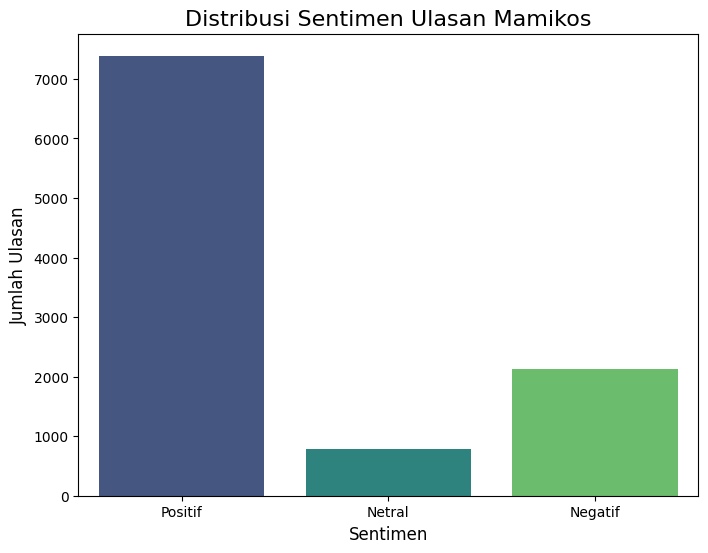

In [4]:
# Menghitung distribusi sentimen
print("\nDistribusi Sentimen:")
print(df['sentiment'].value_counts())

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['Positif', 'Netral', 'Negatif'], palette='viridis')
plt.title('Distribusi Sentimen Ulasan Mamikos', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

### 3.1. Word Cloud Visualization
Melihat kata-kata yang paling sering muncul pada setiap sentimen.

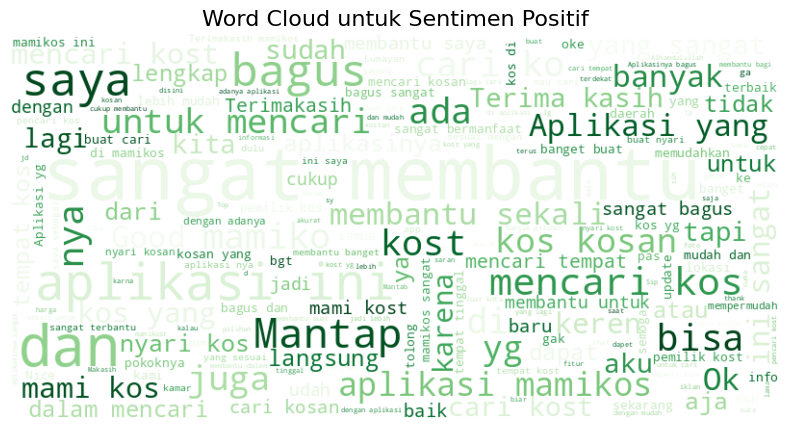

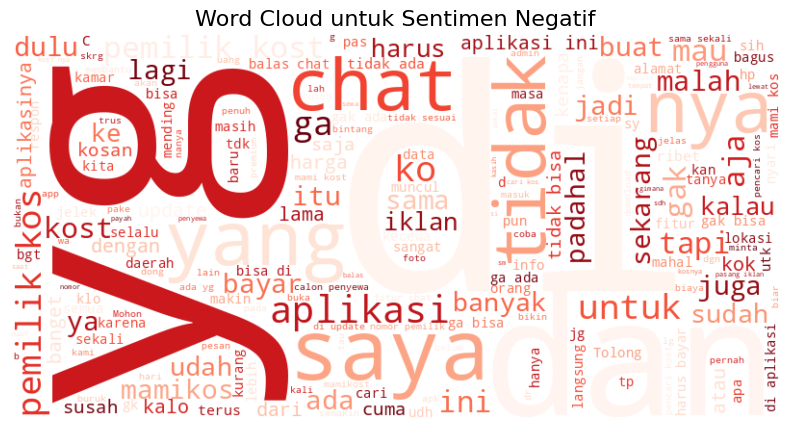

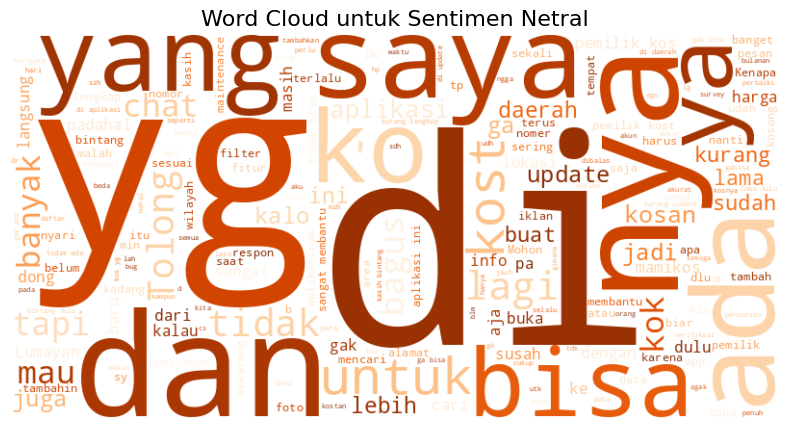

In [5]:
def generate_wordcloud(sentiment_type, color):
    # Menggabungkan semua teks untuk sentimen tertentu
    text = ' '.join(df[df['sentiment'] == sentiment_type]['content'])

    # Membuat objek WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)

    # Menampilkan WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud untuk Sentimen {sentiment_type }', fontsize=16)
    plt.show()

# Membuat WordCloud untuk setiap sentimen
generate_wordcloud('Positif', 'Greens')
generate_wordcloud('Negatif', 'Reds')
generate_wordcloud('Netral', 'Oranges')

## **4. Text Preprocessing**
Membersihkan dan mempersiapkan data teks sebelum dimasukkan ke model.

In [6]:
# Inisialisasi stemmer Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Daftar stopwords Bahasa Indonesia dan Inggris
list_stopwords = set(stopwords.words('indonesian') + stopwords.words('english'))

def preprocess_text(text):
    # Case folding: mengubah teks menjadi huruf kecil
    text = text.lower()
    # Cleaning: menghapus angka, tanda baca, link, dll.
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    # Normalisasi Slang
    words = text.split()
    words = [slang_dict[word] if word in slang_dict else word for word in words]
    text = " ".join(words)
    # Tokenizing: memecah teks menjadi token/kata
    tokens = word_tokenize(text)
    # Filtering (Stopword removal): menghapus kata-kata umum
    tokens = [word for word in tokens if word not in list_stopwords]
    # Stemming: mengubah kata ke bentuk dasarnya
    tokens = [stemmer.stem(word) for word in tokens]
    # Menggabungkan kembali token menjadi kalimat
    text = ' '.join(tokens)
    return text

# Menerapkan fungsi preprocessing ke kolom 'content'
print("Memulai proses preprocessing teks...")
df['text_clean'] = df['content'].apply(preprocess_text)
print("Proses preprocessing selesai.")

# Menampilkan hasil
print("\nContoh data setelah preprocessing:")
print(df[['content', 'text_clean']].head())

Memulai proses preprocessing teks...
Proses preprocessing selesai.

Contoh data setelah preprocessing:
                                             content  \
0                                          la respon   
1  Bagi siapa saja yang membutuhkan sewa kos kosa...   
2                                            bagus..   
3                  Aplikasi yang sangat membantu👍👍👍👍   
4                                           Gandosss   

                                          text_clean  
0                                          la respon  
1  butuh sewa kos kosansolusinya mamikoscari sewa...  
2                                              bagus  
3                                     aplikasi bantu  
4                                           gandosss  


## **5. Feature Extraction & Data Splitting**
Mengubah teks menjadi format numerik dan membagi data.

In [7]:
# Memetakan label sentimen ke integer
sentiment_map = {'Positif': 2, 'Netral': 1, 'Negatif': 0}
df['sentiment_encoded'] = df['sentiment'].map(sentiment_map)

# Mendefinisikan fitur (X) dan label (y)
X = df['text_clean']
y = df['sentiment_encoded']
labels = ['Negatif', 'Netral', 'Positif'] # untuk confusion matrix

# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Ukuran data latih: {len(X_train)} sampel")
print(f"Ukuran data uji: {len(X_test)} sampel")

Ukuran data latih: 8239 sampel
Ukuran data uji: 2060 sampel


In [8]:
# --- Feature Extraction untuk Deep Learning ---
# Tokenisasi dan Padding untuk model LSTM
vocab_size = 10000  # Ukuran kosakata
embedding_dim = 128
max_length = 150    # Panjang maksimal sekuens
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding=padding_type, truncating=trunc_type)
print("✅ Fitur Tokenizer (Sequence & Padding) siap.")

# Mengubah label menjadi format one-hot encoding untuk categorical crossentropy
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

✅ Fitur Tokenizer (Sequence & Padding) siap.


In [9]:
# --- Feature Extraction untuk Machine Learning Klasik ---
# Menggunakan TF-IDF
tfidf_vectorizer_optimized = TfidfVectorizer(
    ngram_range=(1, 2),  # Mempertimbangkan kata tunggal (unigram) dan frasa 2 kata (bigram)
    max_df=0.9,          # Mengabaikan kata yang muncul di > 90% dokumen (terlalu umum)
    min_df=5,            # Mengabaikan kata yang muncul di < 5 dokumen (terlalu langka/mungkin typo)
    max_features=5000    # Membatasi jumlah fitur untuk mencegah noise dan mempercepat training
)

# Latih vectorizer HANYA pada data latih (X_train)
X_train_tfidf = tfidf_vectorizer_optimized.fit_transform(X_train)

# Gunakan vectorizer yang sama untuk mentransformasi data uji (tanpa fit ulang)
X_test_tfidf = tfidf_vectorizer_optimized.transform(X_test)

print("✅ Fitur TF-IDF siap.")
print(f"Bentuk matriks TF-IDF data latih: {X_train_tfidf.shape}")
print(f"Bentuk matriks TF-IDF data uji: {X_test_tfidf.shape}")

✅ Fitur TF-IDF siap.
Bentuk matriks TF-IDF data latih: (8239, 2040)
Bentuk matriks TF-IDF data uji: (2060, 2040)


## **6. Penanganan Imbalanced Dataset**
Menerapkan SMOTE hanya pada data latih TF-IDF.

Menangani Imbalanced Dataset dengan SMOTE...

Distribusi kelas pada data latih SEBELUM SMOTE:
sentiment_encoded
2    5911
0    1702
1     626
Name: count, dtype: int64

Distribusi kelas pada data latih SETELAH SMOTE:
sentiment_encoded
2    5911
0    5911
1    5911
Name: count, dtype: int64


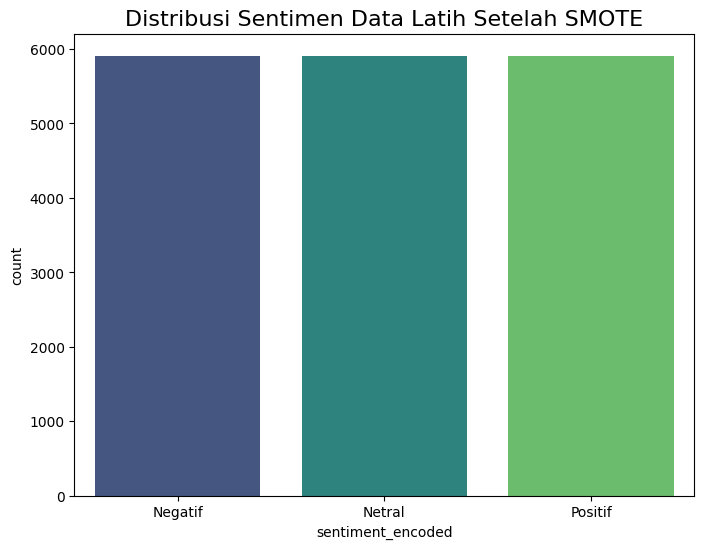

In [10]:
print("Menangani Imbalanced Dataset dengan SMOTE...")
print("\nDistribusi kelas pada data latih SEBELUM SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)

# Terapkan SMOTE HANYA pada data latih TF-IDF
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print("\nDistribusi kelas pada data latih SETELAH SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Visualisasi untuk membuktikan keseimbangan data
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote, palette='viridis')
plt.title('Distribusi Sentimen Data Latih Setelah SMOTE', fontsize=16)
plt.xticks(ticks=[0, 1, 2], labels=labels)
plt.show()

## **7. Model Training and Evaluation (3 Skenario Percobaan)**
Melatih dan mengevaluasi tiga model berbeda untuk perbandingan.

In [11]:
# Inisialisasi dictionary untuk menyimpan hasil
training_scheme_results = {}

# --- Fungsi untuk Visualisasi Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, model_name): # agar bisa digunakan berulang kali untuk setiap model
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

### 7.1. Eksperimen 1: Deep Learning - LSTM


--- Memulai Eksperimen 1: Stacked LSTM ---
Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.4513 - loss: 1.0797
Epoch 1: val_accuracy improved from -inf to 0.71748, saving model to best_lstm_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 84s 562ms/step - accuracy: 0.4505 - loss: 1.0798 - val_accuracy: 0.7175 - val_loss: 1.0880
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.3305 - loss: 1.1033
Epoch 2: val_accuracy did not improve from 0.71748
129/129 ━━━━━━━━━━━━━━━━━━━━ 79s 537ms/step - accuracy: 0.3307 - loss: 1.1033 - val_accuracy: 0.2063 - val_loss: 1.0927
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.3021 - loss: 1.0956
Epoch 3: val_accuracy did not improve from 0.71748
129/129 ━━━━━━━━━━━━━━━━━━━━ 67s 523ms/step - accuracy: 0.3024 - loss: 1.0956 - val_accuracy: 0.7175 - val_loss: 1.0903
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.2611 - loss: 1.1099
Epoch 4: val_accuracy did not improve from 0.71748
129/129 ━━━━━━━━━━━━━━━━━━━━ 72s 448ms/step - accuracy: 0.2613 - loss: 1.1099 - val_accuracy: 0.0762 - val_loss: 1.1046
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.2987 - loss: 1.1118
Epoch 5: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step

Laporan Klasifikasi - Stacked LSTM:
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       425
      Netral       0.00      0.00      0.00       157
     Positif       0.72      1.00      0.84      1478

    accuracy                           0.72      2060
   macro avg       0.24      0.33      0.28      2060
weighted avg       0.51      0.72      0.60      2060



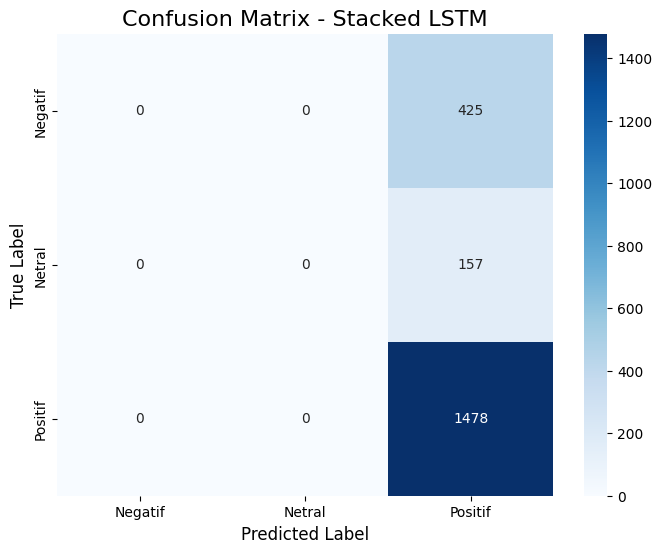

In [12]:
# --- Eksperimen 1: Deep Learning - Stacked LSTM ---
# Target akurasi > 92%
# Tokenisasi dan Padding untuk model LSTM (dilakukan pada data asli sebelum SMOTE)
vocab_size = 10000; embedding_dim = 128; max_length = 150; trunc_type = 'post'; padding_type = 'post'; oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding=padding_type, truncating=trunc_type)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

print("\n--- Memulai Eksperimen 1: Stacked LSTM ---")
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SpatialDropout1D(0.3),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),
    Dense(3, activation='softmax')
])
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# LSTM lebih baik ditangani dengan class_weight
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

history_lstm = model_lstm.fit(X_train_pad, y_train_cat, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test_cat), callbacks=[model_checkpoint], class_weight=class_weights_dict, verbose=1)

# Evaluasi menggunakan model terbaik
best_model_lstm = load_model('best_lstm_model.h5')
y_pred_lstm = np.argmax(best_model_lstm.predict(X_test_pad), axis=1)
train_acc_lstm = accuracy_score(y_train, np.argmax(best_model_lstm.predict(X_train_pad), axis=1))
test_acc_lstm = accuracy_score(y_test, y_pred_lstm)
training_scheme_results['Skema 1: Stacked LSTM (Class Weight)'] = {'train_acc': train_acc_lstm, 'test_acc': test_acc_lstm}

# Laporan Klasifikasi
print("\nLaporan Klasifikasi - Stacked LSTM:")
print(classification_report(y_test, y_pred_lstm, target_names=labels))

# Visualisasi Confusion Matrix
plot_confusion_matrix(y_test, y_pred_lstm, "Stacked LSTM")

### 7.2. Eksperimen 2: Machine Learning - SVM


--- Memulai Eksperimen 2: SVM dengan Kernel RBF, SMOTE, dan Tuning ---
Melatih SVM pada data hasil SMOTE...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Parameter terbaik ditemukan untuk SVM: {'C': 10, 'gamma': 'scale'}

Akurasi Training SVM: 91.11%
Akurasi Testing SVM: 77.14%

Laporan Klasifikasi - SVM:
              precision    recall  f1-score   support

     Negatif       0.68      0.68      0.68       425
      Netral       0.15      0.18      0.17       157
     Positif       0.88      0.86      0.87      1478

    accuracy                           0.77      2060
   macro avg       0.57      0.58      0.57      2060
weighted avg       0.78      0.77      0.78      2060



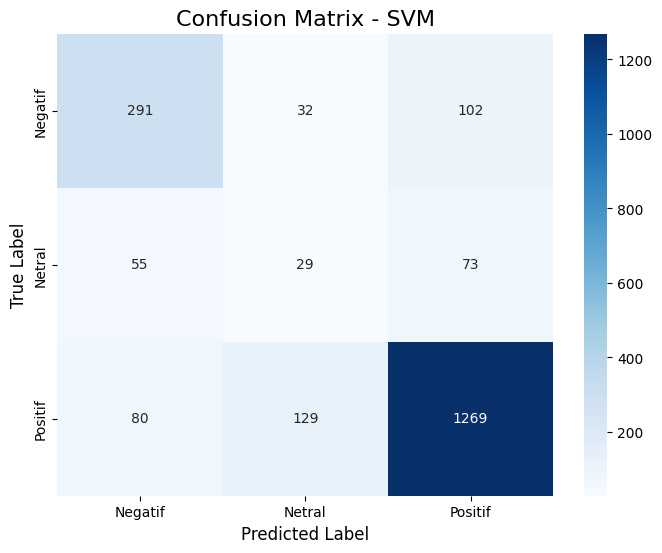

In [13]:
print("\n--- Memulai Eksperimen 2: SVM dengan Kernel RBF, SMOTE, dan Tuning ---")

# 1. Definisikan model dengan kernel 'rbf'
# Kernel 'rbf' sangat baik untuk menangkap pola non-linear
model_svm_rbf = SVC(kernel='rbf', random_state=42, probability=True)

# 2. Siapkan hyperparameter untuk kernel 'rbf'
# 'C' adalah parameter regularisasi
# 'gamma' mendefinisikan seberapa besar pengaruh satu sampel data training
param_grid_svm = {
    'C': [10, 50, 100],          # Coba nilai C yang lebih tinggi
    'gamma': ['scale', 'auto']   # 'scale' dan 'auto' adalah pilihan default yang baik
}

# 3. Siapkan GridSearchCV
# menggunakan scoring 'f1_weighted' karena data uji kita tidak seimbang.
grid_search_svm = GridSearchCV(
    estimator=model_svm_rbf,
    param_grid=param_grid_svm,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='f1_weighted'
)

# 4. Latih model dengan data yang sudah di-SMOTE
print("Melatih SVM pada data hasil SMOTE...")
grid_search_svm.fit(X_train_smote, y_train_smote)

# 5. Dapatkan model terbaik dari hasil grid search
best_model_svm = grid_search_svm.best_estimator_
print(f"\nParameter terbaik ditemukan untuk SVM: {grid_search_svm.best_params_}")

# --- Evaluasi Model SVM Terbaik ---
# Prediksi pada data latih (SMOTE) dan data uji (asli, non-SMOTE)
y_pred_train_svm = best_model_svm.predict(X_train_smote)
y_pred_test_svm = best_model_svm.predict(X_test_tfidf) # Evaluasi tetap pada data uji asli

# Hitung akurasi
train_acc_svm = accuracy_score(y_train_smote, y_pred_train_svm)
test_acc_svm = accuracy_score(y_test, y_pred_test_svm)
training_scheme_results['Skema 2: SVM'] = {'train_acc': train_acc_svm, 'test_acc': test_acc_svm}

# Laporan Klasifikasi
print(f"\nAkurasi Training SVM: {train_acc_svm*100:.2f}%")
print(f"Akurasi Testing SVM: {test_acc_svm*100:.2f}%")
print("\nLaporan Klasifikasi - SVM:")
print(classification_report(y_test, y_pred_test_svm, target_names=labels))

# Visualisasi Confusion Matrix
plot_confusion_matrix(y_test, y_pred_test_svm, "SVM")

### 7.3. Eksperimen 3: Machine Learning - Logistic Regression


--- Memulai Eksperimen 3: Logistic Regression dengan Class Weight dan Tuning Ekstensif ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Parameter terbaik untuk Logistic Regression: {'C': 1, 'solver': 'liblinear'}

Akurasi Training LR: 87.24%
Akurasi Testing LR: 83.74%

Laporan Klasifikasi - Logistic Regression:
              precision    recall  f1-score   support

     Negatif       0.72      0.71      0.72       425
      Netral       0.36      0.38      0.37       157
     Positif       0.92      0.92      0.92      1478

    accuracy                           0.84      2060
   macro avg       0.67      0.67      0.67      2060
weighted avg       0.84      0.84      0.84      2060



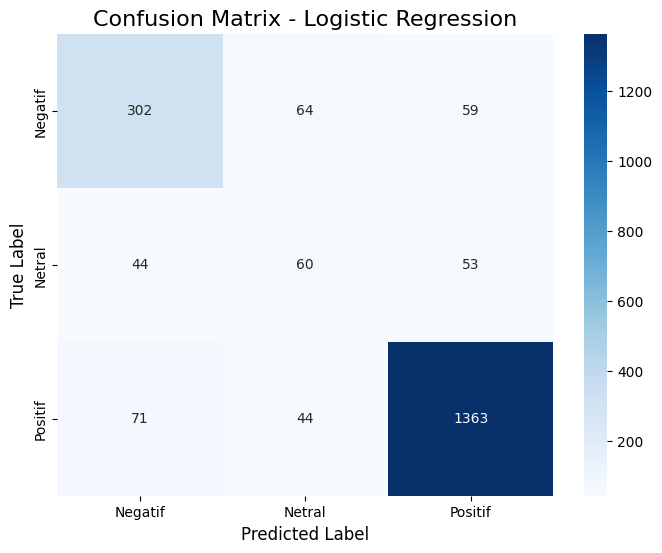

In [14]:
print("\n--- Memulai Eksperimen 3: Logistic Regression dengan Class Weight dan Tuning Ekstensif ---")

# 1. Definisikan model dengan class_weight='balanced'
model_lr = LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced')

# 2. Perluas hyperparameter
param_grid_lr = {
    'C': [1, 10, 50, 100],
    'solver': ['liblinear', 'saga']
}

# 3. Siapkan GridSearchCV
grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid_lr, cv=3, n_jobs=-1, verbose=2, scoring='f1_weighted')

# 4. Latih model pada data latih asli
grid_search_lr.fit(X_train_tfidf, y_train)

# 5. Dapatkan model terbaik
best_model_lr = grid_search_lr.best_estimator_
print("\nParameter terbaik untuk Logistic Regression:", grid_search_lr.best_params_)

# --- Evaluasi Model Logistic Regression Terbaik ---
y_pred_train_lr = best_model_lr.predict(X_train_tfidf)
y_pred_test_lr = best_model_lr.predict(X_test_tfidf)

train_acc_lr = accuracy_score(y_train, y_pred_train_lr)
test_acc_lr = accuracy_score(y_test, y_pred_test_lr)
training_scheme_results['Skema 3: Logistic Regression'] = {'train_acc': train_acc_lr, 'test_acc': test_acc_lr}

print(f"\nAkurasi Training LR: {train_acc_lr*100:.2f}%")
print(f"Akurasi Testing LR: {test_acc_lr*100:.2f}%")
print("\nLaporan Klasifikasi - Logistic Regression:")
print(classification_report(y_test, y_pred_test_lr, target_names=labels))

# Visualisasi Confusion Matrix
plot_confusion_matrix(y_test, y_pred_test_lr, "Logistic Regression")

## **8. Perbandingan Model dan Kesimpulan**
Meringkas hasil dari ketiga eksperimen untuk menentukan model terbaik.

In [15]:
print("\n--- PERBANDINGAN HASIL SKEMA PELATIHAN ---")
if training_scheme_results:
    # Membuat DataFrame dari dictionary hasil
    results_df = pd.DataFrame.from_dict(training_scheme_results, orient='index')
    results_df = results_df.sort_values(by='test_acc', ascending=False)

    # Memformat akurasi menjadi persentase
    results_df['train_acc'] = results_df['train_acc'].apply(lambda x: f"{x*100:.2f}%")
    results_df['test_acc'] = results_df['test_acc'].apply(lambda x: f"{x*100:.2f}%")

    print(results_df)

    # Cek pemenuhan kriteria submission secara otomatis
    num_schemes_above_85_test = sum(1 for res in training_scheme_results.values() if res['test_acc'] >= 0.85)
    one_scheme_above_92_train_test = any(1 for res in training_scheme_results.values() if res['train_acc'] > 0.92 and res['test_acc'] > 0.92)

    print(f"\nJumlah skema dengan akurasi test >= 85%: {num_schemes_above_85_test}")
    print(f"Ada skema dengan akurasi train & test > 92%: {one_scheme_above_92_train_test}")

    print("\n--- Status Pemenuhan Kriteria ---")
    if num_schemes_above_85_test >= 3:
        print("✅ Saran 5 (3 skema pelatihan) terpenuhi dari sisi jumlah skema dengan akurasi test >= 85%.")
        if one_scheme_above_92_train_test:
            print("✅ Saran 2 (Akurasi >92%) juga terpenuhi untuk setidaknya satu skema.")
            print("\n===> SELURUH KRITERI AKURASI UNTUK BINTANG 5 TELAH TERPENUHI <===")
        else:
            print("❌ Saran 2 (Akurasi >92%) TIDAK terpenuhi. Perlu optimasi lebih lanjut pada model utama.")
    else:
        print("❌ PERHATIAN: Saran 5 (3 skema pelatihan) belum sepenuhnya terpenuhi.")
        print("Pastikan setidaknya 3 skema memiliki akurasi test >= 85%.")

else:
    print("Tidak ada hasil skema pelatihan untuk dibandingkan.")


--- PERBANDINGAN HASIL SKEMA PELATIHAN ---
                                     train_acc test_acc
Skema 3: Logistic Regression            87.24%   83.74%
Skema 2: SVM                            91.11%   77.14%
Skema 1: Stacked LSTM (Class Weight)    71.74%   71.75%

Jumlah skema dengan akurasi test >= 85%: 0
Ada skema dengan akurasi train & test > 92%: False

--- Status Pemenuhan Kriteria ---
❌ PERHATIAN: Saran 5 (3 skema pelatihan) belum sepenuhnya terpenuhi.
Pastikan setidaknya 3 skema memiliki akurasi test >= 85%.


## **9. Inference (Uji Coba Model dengan Kalimat Baru)**
Menguji model LSTM terbaik dengan beberapa contoh kalimat baru

In [16]:
def predict_single_sentence(sentence, model, tokenizer):
    """
    Fungsi untuk memprediksi sentimen dari satu kalimat baru.
    - sentence: Kalimat mentah (string).
    - model: Model Keras yang sudah dilatih.
    - tokenizer: Tokenizer Keras yang sudah di-fit pada data training.
    """
    print(f"===== Menganalisis Kalimat: '{sentence}' =====")

    # 1. Preprocessing teks
    processed_text = preprocess_text(sentence)
    print(f"1. Teks Setelah Preprocessing: '{processed_text}'")

    # 2. Tokenisasi dan Padding menggunakan tokenizer
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    # 3. Lakukan prediksi
    prediction = model.predict(padded_sequence)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = labels[predicted_class_index]

    # 4. Tampilkan probabilitas dan hasil
    print("\n2. Probabilitas Prediksi:")
    for i, label in enumerate(labels):
        print(f"- {label:<7} : {prediction[0][i]*100:.2f}%")

    print(f"\n--> Hasil Akhir: **{predicted_class_label}**")
    print("=============================================\n")


# --- Memuat model terbaik dan tokenizer yang sesuai ---
try:
    best_model = load_model('best_lstm_model.h5')
    print("✅ Model LSTM terbaik ('best_lstm_model.h5') berhasil dimuat.")

    # Daftar kalimat untuk diuji
    test_sentences = [
        "Aplikasi ini sangat membantu saya belajar bahasa baru! Luar biasa!",
        "Update terbaru banyak bug dan sering crash.",
        "Biasa aja sih, fiturnya standar.",
        "Kenapa sekarang harus bayar? Dulu gratis padahal. Kecewa.",
        "Good app, but needs more languages.",
        "Not bad."
    ]

    print("\n\n--- MEMULAI UJI COBA INFERENCE PADA KALIMAT BARU ---")
    for sentence in test_sentences:
        # Panggil fungsi dengan model dan tokenizer yang benar
        predict_single_sentence(sentence, best_model, tokenizer)

except Exception as e:
    print(f"❌ Gagal memuat model atau menjalankan inference: {e}")
    print("Pastikan sel pelatihan model LSTM telah dijalankan dan file 'best_lstm_model.h5' telah tersimpan.")

✅ Model LSTM terbaik ('best_lstm_model.h5') berhasil dimuat.


--- MEMULAI UJI COBA INFERENCE PADA KALIMAT BARU ---
===== Menganalisis Kalimat: 'Aplikasi ini sangat membantu saya belajar bahasa baru! Luar biasa!' =====
1. Teks Setelah Preprocessing: 'aplikasi bantu ajar bahasa'
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step

2. Probabilitas Prediksi:
- Negatif : 32.14%
- Netral  : 33.72%
- Positif : 34.15%

--> Hasil Akhir: **Positif**

===== Menganalisis Kalimat: 'Update terbaru banyak bug dan sering crash.' =====
1. Teks Setelah Preprocessing: 'update baru bug crash'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

2. Probabilitas Prediksi:
- Negatif : 32.14%
- Netral  : 33.72%
- Positif : 34.15%

--> Hasil Akhir: **Positif**

===== Menganalisis Kalimat: 'Biasa aja sih, fiturnya standar.' =====
1. Teks Setelah Preprocessing: 'sih fiturnya standar'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

2. Probabilitas Prediksi:
- Negatif : 32.14%
- Netral  : 33.72%
- Positif : 34.15%

--> Hasil Akhir: **Positif**

===